In [61]:
# =========================
# 1) Imports & paden
# =========================
from pathlib import Path
from datetime import datetime
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import (
    mean_absolute_percentage_error,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.inspection import permutation_importance
import sklearn

from src.clean import clean_dataframe
from src.features import build_features, FEATURE_ORDER, CATEGORICAL, NUMERIC

DATA_IN   = Path("data/processed/train.csv")         # of train_clean.csv als je die gebruikt
MODEL_OUT = Path("models/model.joblib")              # bundel (pipe + cal + meta)
METRICS   = Path("reports/metrics.json")

MODEL_OUT.parent.mkdir(parents=True, exist_ok=True)
METRICS.parent.mkdir(parents=True, exist_ok=True)

print("Versions →", "sklearn:", sklearn.__version__, "| pandas:", pd.__version__)


Versions → sklearn: 1.7.1 | pandas: 2.3.2


In [62]:
# =========================
# 2) Data laden & cleanen
# =========================
raw = pd.read_csv(DATA_IN, sep=";")
df, rep = clean_dataframe(raw, require_target=True, keep_only_region="north")
print("Rows before/after:", rep.n_rows_before, "→", rep.n_rows_after)
print("Dropped by reason:", rep.dropped_by_reason)
print("Missing after:", rep.n_missing_after)

df.head(3)


Rows before/after: 2886 → 1286
Dropped by reason: {'reportType != north': 1420, 'invalid Start': 180}
Missing after: {'Programma': 0, 'Zender': 0, 'Datum': 0, 'Start': 0, 'Duur': 0, 'Kijkcijfers': 0, 'ranking': 0, 'period': 0, 'reportType': 0}


,Programma,Zender,Datum,Start,Duur,Kijkcijfers,ranking,period,reportType
0,DE AFSPRAAK,Canvas,2022-01-25,1235,46,231935,17,daily,north
1,THERAPIE,Canvas,2022-01-25,1285,39,226539,19,daily,north
2,BAPTISTE,EEN,2022-01-25,1293,54,453800,10,daily,north


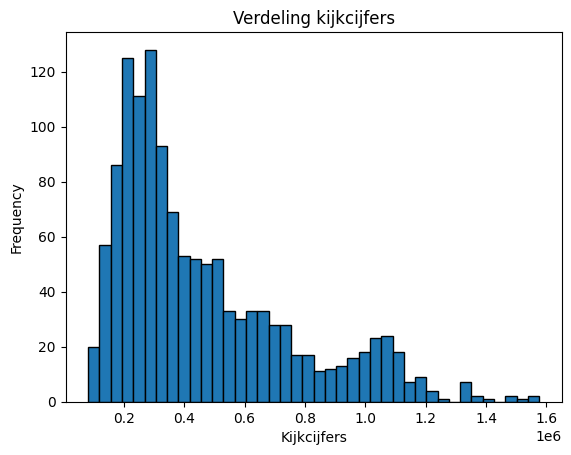

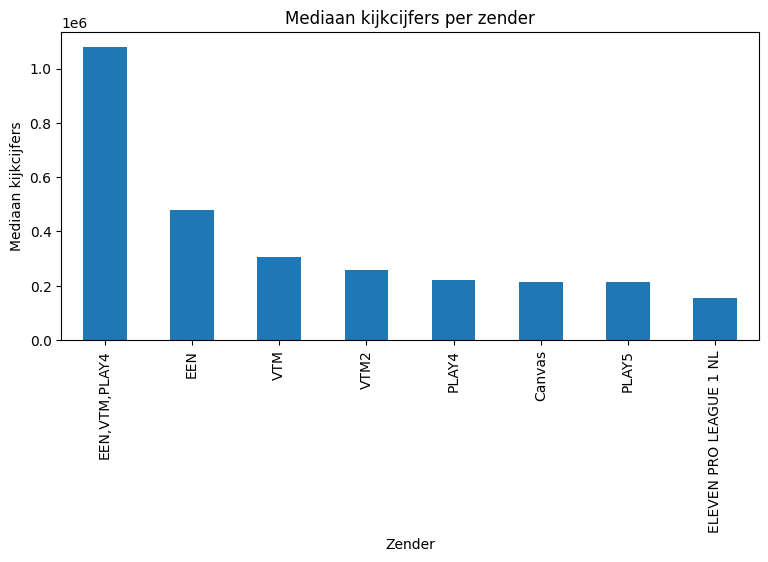

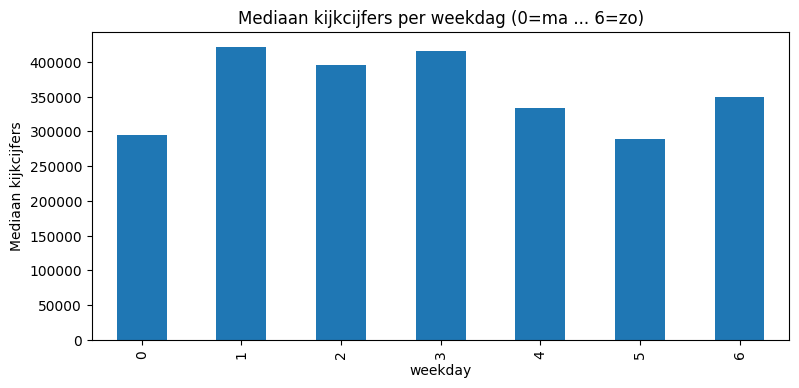

In [63]:
# =========================
# 3) Snelle EDA
# =========================
plt.figure()
df["Kijkcijfers"].plot(kind="hist", bins=40, edgecolor="black")
plt.title("Verdeling kijkcijfers")
plt.xlabel("Kijkcijfers")
plt.show()

plt.figure(figsize=(9,4))
(df.groupby("Zender")["Kijkcijfers"].median()
   .sort_values(ascending=False)
   .plot(kind="bar"))
plt.title("Mediaan kijkcijfers per zender")
plt.ylabel("Mediaan kijkcijfers")
plt.show()

# Weekdag-effect
df["Datum"] = pd.to_datetime(df["Datum"], errors="coerce")  # cleaner deed dit ook, defensief nogmaals
df["weekday"] = df["Datum"].dt.weekday  # 0=ma
plt.figure(figsize=(9,4))
(df.groupby("weekday")["Kijkcijfers"].median()
   .reindex([0,1,2,3,4,5,6])
   .plot(kind="bar"))
plt.title("Mediaan kijkcijfers per weekdag (0=ma ... 6=zo)")
plt.ylabel("Mediaan kijkcijfers")
plt.show()


In [50]:
# =========================
# 4) Feature engineering
# =========================
fdf = build_features(df)              # voegt weekday/is_weekend/month/prime_time/start_bin toe
features_all = fdf[FEATURE_ORDER]     # exacte volgorde die model verwacht
y_all = df["Kijkcijfers"].astype(float).to_numpy()

print("Features:", FEATURE_ORDER)
features_all.head(3)


Features: ['Programma', 'Zender', 'start_bin', 'Start', 'Duur', 'weekday', 'is_weekend', 'month', 'prime_time']


,Programma,Zender,start_bin,Start,Duur,weekday,is_weekend,month,prime_time
7,THIRTIEN LIVES,PLAY4,prime,1230,133,5,1,6,1
21,ANDERMANS ZAKEN,VRT 1,middag,817,50,5,1,6,0
22,CHANTAL,VRT 1,prime,1258,44,5,1,6,1


In [51]:
# =========================
# 5) Tijdssplit (80/20)
# =========================
fdf_sorted = fdf.sort_values("Datum").reset_index(drop=True)
df_sorted  = df.sort_values("Datum").reset_index(drop=True)   # ← voeg toe
y_sorted   = y_all[fdf_sorted.index]  # posities zijn gelijk aan nieuwe index

split_idx = int(len(fdf_sorted) * 0.8)
assert 0 < split_idx < len(fdf_sorted), "Dataset te klein of split onlogisch."

X_train = fdf_sorted[FEATURE_ORDER].iloc[:split_idx]
X_test  = fdf_sorted[FEATURE_ORDER].iloc[split_idx:]
y_train = y_sorted[:split_idx]
y_test  = y_sorted[split_idx:]


In [52]:
# =========================
# 6) Preprocessor + model
# =========================
def build_preprocessor() -> ColumnTransformer:
    # Maak OHE dense (HGB slikt geen sparse)
    try:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # sklearn >=1.2
    except TypeError:
        ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)         # oudere versies

    cat_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot",  ohe),
    ])

    num_pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
    ])

    pre = ColumnTransformer(
        transformers=[
            ("cat", cat_pipe, CATEGORICAL),
            ("num", num_pipe, NUMERIC),
        ],
        sparse_threshold=0.0
    )
    return pre

pre = build_preprocessor()
model = HistGradientBoostingRegressor(random_state=42)
pipe  = Pipeline([("pre", pre), ("model", model)])

pipe


,steps,"[('pre', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [53]:
# =========================
# 7) Train & evaluatie
# =========================
pipe.fit(X_train, y_train)
pred = pipe.predict(X_test)

mape = float(mean_absolute_percentage_error(y_test, pred))
mae  = float(mean_absolute_error(y_test, pred))
rmse = float(np.sqrt(mean_squared_error(y_test, pred)))  # compatibel met oudere sklearn
r2   = float(r2_score(y_test, pred))

print({"MAPE": mape, "MAE": mae, "RMSE": rmse, "R2": r2, "n_train": len(X_train), "n_test": len(X_test)})


{'MAPE': 0.7659407847351213, 'MAE': 150775.1910914849, 'RMSE': 177674.5759138536, 'R2': -0.18336272058264735, 'n_train': 979, 'n_test': 245}


In [54]:
# =========================
# 7b) Model evaluator helper
# =========================
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

def evaluate_model(name, estimator, X_train, y_train, X_test, y_test):
    """
    Bouwt een pipeline met dezelfde preprocessor en de meegegeven estimator,
    fit het model en berekent MAPE/MAE/RMSE/R2.
    Retourneert (result_dict, fitted_pipeline, y_pred).
    """
    # Gebruik dezelfde preprocessor-functie als in je notebook (build_preprocessor)
    pre_local = build_preprocessor()
    pipe_local = Pipeline([("pre", pre_local), ("model", estimator)])
    pipe_local.fit(X_train, y_train)
    y_hat = pipe_local.predict(X_test)

    mape = float(mean_absolute_percentage_error(y_test, y_hat))
    mae  = float(mean_absolute_error(y_test, y_hat))
    rmse = float(np.sqrt(mean_squared_error(y_test, y_hat)))  # compatibel met oudere sklearn
    r2   = float(r2_score(y_test, y_hat))

    res = {
        "Model": name,
        "MAPE": mape,
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2,
    }
    return res, pipe_local, y_hat


Ridge: MAPE=0.7532 | MAE=144966 | RMSE=172363 | R2=-0.114
RandomForest: MAPE=0.7628 | MAE=147978 | RMSE=177446 | R2=-0.180
HistGradientBoosting: MAPE=0.7659 | MAE=150775 | RMSE=177675 | R2=-0.183


,Model,MAPE,MAE,RMSE,R2
0,Ridge,0.753241,144966.164637,172363.353394,-0.113672
1,RandomForest,0.762790,147978.220323,177446.338179,-0.180324
2,HistGradientBoosting,0.765941,150775.191091,177674.575914,-0.183363


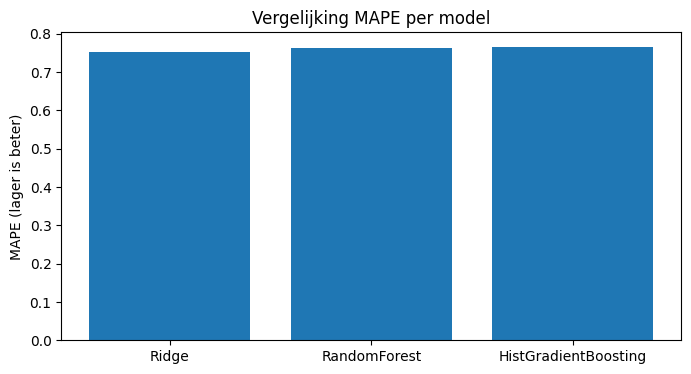

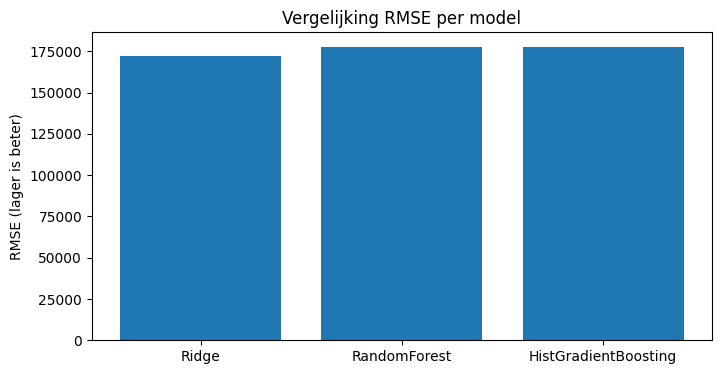


Gekozen eindmodel (op basis van MAPE): Ridge


In [55]:
# =========================
# 7c) Run meerdere modellen & kies beste (MAPE)
# =========================

candidates = [
    ("Ridge", Ridge(alpha=1.0)),
    ("RandomForest", RandomForestRegressor(n_estimators=400, random_state=42, n_jobs=None)),
    ("HistGradientBoosting", HistGradientBoostingRegressor(random_state=42)),
]

results = []
fitted = {}
preds   = {}

for name, est in candidates:
    res, p, yhat = evaluate_model(name, est, X_train, y_train, X_test, y_test)
    results.append(res)
    fitted[name] = p
    preds[name]  = yhat
    print(f"{name}: MAPE={res['MAPE']:.4f} | MAE={res['MAE']:.0f} | RMSE={res['RMSE']:.0f} | R2={res['R2']:.3f}")

# Resultaten in tabel
res_df = pd.DataFrame(results).sort_values("MAPE", ascending=True).reset_index(drop=True)
display(res_df)

# Eenvoudige vergelijking in grafiek (MAPE en RMSE)
plt.figure(figsize=(8,4))
plt.bar(res_df["Model"], res_df["MAPE"])
plt.title("Vergelijking MAPE per model")
plt.ylabel("MAPE (lager is beter)")
plt.show()

plt.figure(figsize=(8,4))
plt.bar(res_df["Model"], res_df["RMSE"])
plt.title("Vergelijking RMSE per model")
plt.ylabel("RMSE (lager is beter)")
plt.show()

# Kies de beste op basis van MAPE
best_name = res_df.iloc[0]["Model"]
best_pipe = fitted[best_name]
best_pred = preds[best_name]

print(f"\nGekozen eindmodel (op basis van MAPE): {best_name}")

# Zorg dat de rest van je notebook (perm. importance, kalibratie, opslaan) dit gebruikt:
pipe = best_pipe   # vervangt de eerder gedefinieerde 'pipe'
pred = best_pred   # vervangt de eerder berekende 'pred'


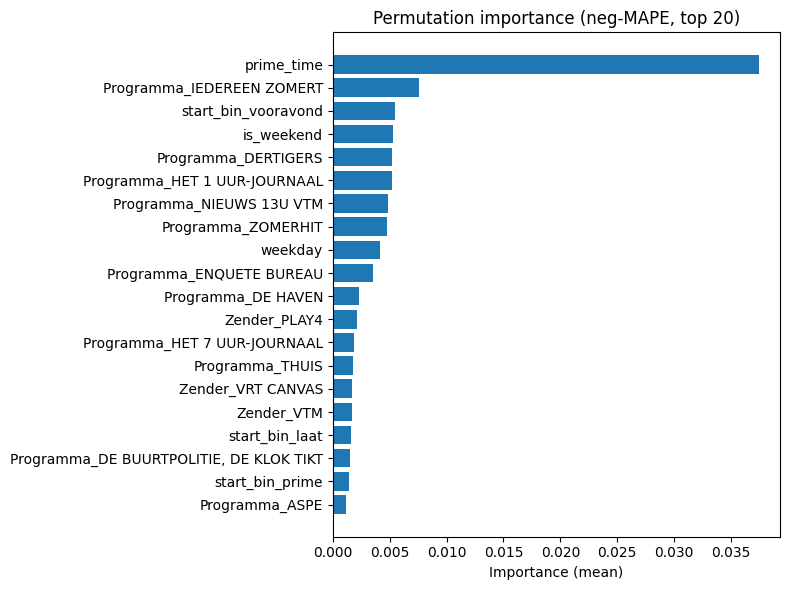

In [56]:
# =========================
# 8) Permutation importance (top 20)
# =========================
def expanded_feature_names(pre: ColumnTransformer) -> list[str]:
    cat = pre.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(CATEGORICAL)
    num = NUMERIC
    return list(cat) + list(num)

Xt_test = pipe.named_steps["pre"].transform(X_test)
pim = permutation_importance(
    pipe.named_steps["model"],
    Xt_test, y_test,
    n_repeats=5, random_state=42,
    scoring="neg_mean_absolute_percentage_error"
)

feat_names = expanded_feature_names(pipe.named_steps["pre"])
order = np.argsort(-pim.importances_mean)
top = min(20, len(order))

plt.figure(figsize=(8, 6))
plt.barh(range(top), pim.importances_mean[order][:top][::-1])
plt.yticks(range(top), [feat_names[i] for i in order[:top]][::-1])
plt.title("Permutation importance (neg-MAPE, top 20)")
plt.xlabel("Importance (mean)")
plt.tight_layout()
plt.show()


In [57]:
# =========================
# 9) Kalibratie (global + per zender)
# =========================
def compute_calibration(y_true: np.ndarray, y_pred: np.ndarray, zenders: np.ndarray,
                        min_count: int = 20, clip_global=(0.5,1.5), clip_per=(0.4,1.6)) -> dict:
    cal = {}
    ps, ts = float(np.sum(y_pred)), float(np.sum(y_true))
    cal["global"] = 1.0 if ps <= 1e-9 else float(np.clip(ts/ps, *clip_global))
    for ch in pd.Series(zenders).astype(str).unique():
        m = (zenders == ch)
        if int(np.sum(m)) >= min_count:
            p, t = float(np.sum(y_pred[m])), float(np.sum(y_true[m]))
            if p > 1e-9:
                cal[ch] = float(np.clip(t/p, *clip_per))
    return cal

z_test = df_sorted["Zender"].astype(str).iloc[split_idx:].to_numpy()
cal = compute_calibration(y_test, pred, z_test, min_count=20)
cal

{'global': 0.926176553542542,
 'VTM': 0.9705475175769512,
 'VRT 1': 0.8818432680644671}

In [58]:
# =========================
# 10) Save bundle + metrics
# =========================
bundle = {
    "pipe": pipe,
    "cal": cal,
    "meta": {
        "trained_at": datetime.utcnow().isoformat() + "Z",
        "sklearn_version": sklearn.__version__,
        "pandas_version": pd.__version__,
        "feature_order": FEATURE_ORDER,
        "categorical": CATEGORICAL,
        "numeric": NUMERIC,
        "split": {"train": int(len(X_train)), "test": int(len(X_test))},
    },
}
import joblib
joblib.dump(bundle, MODEL_OUT)

metrics = {
    "MAPE_raw": mape, "MAE_raw": mae, "RMSE_raw": rmse, "R2_raw": r2,
    "calibration": cal,
}
METRICS.write_text(json.dumps(metrics, indent=2))
MODEL_OUT, METRICS


C:\Users\emile\AppData\Local\Temp\ipykernel_8592\4001012375.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "trained_at": datetime.utcnow().isoformat() + "Z",


(WindowsPath('models/model.joblib'), WindowsPath('reports/metrics.json'))

In [59]:
# =========================
# 11) Inference-dryrun in notebook
# =========================
# Neem de laatste 8 rijen als "exam input" (zonder target)
exam_df = df.iloc[-8:][["Programma","Zender","Datum","Start","Duur"]].copy()

# Zelfde cleaning & features als training
exam_clean, _ = clean_dataframe(exam_df, require_target=False, keep_only_region="north")
exam_feats = build_features(exam_clean)[FEATURE_ORDER]

# Ruwe voorspelling
pred_exam = pipe.predict(exam_feats)

# Kalibratie toepassen
z = exam_clean["Zender"].astype(str).values
factors = np.array([cal.get(zz, cal.get("global", 1.0)) for zz in z], dtype=float)
pred_final = np.maximum(0, np.round((pred_exam * factors) / 10.0) * 10).astype(int)

# Resultaat tonen
pred_out = exam_clean.copy()
pred_out["VoorspeldeKijkcijfers"] = pred_final
pred_out


,Programma,Zender,Datum,Start,Duur,VoorspeldeKijkcijfers
2727,WIELRENNEN. VUELTA - RIT 2 ALBA>LIMONE PIEMONTE,VRT 1,2025-08-24,963,107,245540
2728,HET GEHEUGENSPEL,VTM,2025-08-24,1236,97,287480
2729,LILI EN MARLEEN,VTM,2025-08-24,1198,27,313540
2730,NIEUWS 13U VTM,VTM,2025-08-24,780,21,339360
2731,NIEUWS 19U VTM,VTM,2025-08-24,1140,46,254640
2732,"ZILLION, THE LOST TAPES",VTM,2025-08-24,1360,37,280410
2733,AXEL GAAT BINNEN,VTM2,2025-08-24,1163,54,264460
2734,INFERNO,VTM2,2025-08-24,1233,111,227500


## optioneel

In [60]:
# =========================
# 12) Bewaar predictions (optioneel)
# =========================
pred_path = Path("data/processed/predictions_notebook.csv")
pred_out.to_csv(pred_path, sep=";", index=False, encoding="utf-8-sig")
pred_path


WindowsPath('data/processed/predictions_notebook.csv')

In [64]:
import pandas as pd
from src.features import build_features, FEATURE_ORDER

df_tv = pd.read_csv("data/processed/train.csv", sep=";")
fdf = build_features(df_tv)

print("Columns in features:", fdf.columns.tolist())
print("Weather columns present:", [c for c in fdf.columns if "rain" in c or "temp" in c or "sun" in c])

print(fdf[["Datum","rain_mm","temp_max_c","sunshine_h"]].head(15))
print("NaN counts:\n", fdf[["rain_mm","temp_max_c","sunshine_h"]].isna().sum())


Columns in features: ['Datum', 'Programma', 'Zender', 'start_bin', 'Start', 'Duur', 'weekday', 'is_weekend', 'month', 'prime_time']
Weather columns present: []


KeyError: "['rain_mm', 'temp_max_c', 'sunshine_h'] not in index"